In [8]:
import numpy as np
import pandas as pd
from scipy.signal import coherence, butter, filtfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
import mne

In [9]:
patient_num = 2

eeg_task_path = f'../Data/Processed/sub0{patient_num}_binned_task.csv'
eeg_data = pd.read_csv(eeg_task_path)

In [10]:
def bandpass_filter(data, low_freq, high_freq, sf):
    nyquist = 0.5 * sf
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data)

In [11]:
def compute_coherence(signal1, signal2, sfreq, band, nperseg=256):
    # Apply band-pass filter before coherence calculation
    filtered_signal1 = bandpass_filter(signal1, band[0], band[1], sfreq)
    filtered_signal2 = bandpass_filter(signal2, band[0], band[1], sfreq)
    f, Cxy = coherence(filtered_signal1, filtered_signal2, fs=sfreq, nperseg=nperseg)
    return np.mean(Cxy)

In [12]:
def extract_connectivity_features(eeg_data, selected_electrodes, sfreq=512):
    features = []
    labels = []
    electrode_pairs = [(e1, e2) for i, e1 in enumerate(selected_electrodes) for e2 in selected_electrodes[i+1:]]
    
    for idx, row in tqdm.tqdm(eeg_data.iterrows(), total=eeg_data.shape[0], desc='Extracting Features'):
        trial_features = []
        for e1, e2 in electrode_pairs:
            # Convert stored strings to lists of floats
            signal1 = np.array(eval(row[e1]))
            signal2 = np.array(eval(row[e2]))
            
            # Extract coherence in different frequency bands
            delta_coherence = compute_coherence(signal1, signal2, sfreq, (0.5, 4), nperseg=256)
            theta_coherence = compute_coherence(signal1, signal2, sfreq, (4, 8), nperseg=256)
            alpha_coherence = compute_coherence(signal1, signal2, sfreq, (8, 12), nperseg=256)
            beta_coherence = compute_coherence(signal1, signal2, sfreq, (12, 30), nperseg=256)
            
            # Append coherence features for this electrode pair
            trial_features.extend([delta_coherence, theta_coherence, alpha_coherence, beta_coherence])
        
        # Print sample coherence values for the first trial for diagnostics
        if idx == 0:
            print(f"Sample Coherence Values for Trial {idx}:")
            print(f"Delta: {delta_coherence}, Theta: {theta_coherence}, Alpha: {alpha_coherence}, Beta: {beta_coherence}")

        features.append(trial_features)
        labels.append(1 if row['label_type'] == 'social' else 0)
    
    return np.array(features), np.array(labels), electrode_pairs

In [13]:
selected_electrodes = [
    'O1', 'O2', 'Oz', 'POz', 'PO3', 'PO4', 'PO7', 'PO8',
    'F3', 'F4', 'Fz', 'F7', 'F8', 'AF3', 'AF4', 'AF7', 'AF8', 'Fpz',
    'T7', 'T8', 'Cz', 'Pz', 'FCz', 'CP1', 'CP2'
]

In [14]:
X, y, electrode_pairs = extract_connectivity_features(eeg_data, selected_electrodes)
print(f"Shape of extracted features: {X.shape}")

Extracting Features:   0%|          | 1/319 [00:02<11:46,  2.22s/it]

Sample Coherence Values for Trial 0:
Delta: 0.40235957220650415, Theta: 0.06605813470445014, Alpha: 0.20485693351456705, Beta: 0.4847550012853848


Extracting Features: 100%|██████████| 319/319 [11:45<00:00,  2.21s/it]

Shape of extracted features: (319, 1200)


In [15]:
print("Sample Coherence Values (first 5 rows):")
print(X[:5])

Sample Coherence Values (first 5 rows):
[[0.24953898 0.17344938 0.61045994 ... 0.06605813 0.20485693 0.484755  ]
 [0.41689681 0.50231156 0.81687713 ... 0.0522728  0.22790827 0.43328839]
 [0.87854533 0.64184705 0.44114279 ... 0.24757607 0.52445451 0.27585026]
 [0.03802724 0.73812405 0.58429309 ... 0.59417892 0.62155194 0.51262659]
 [0.61728214 0.1196238  0.70893782 ... 0.09862444 0.11747578 0.18396036]]


In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
print(X[:5])

[[-0.64728872 -1.30084726  0.37200619 ... -1.20159722 -1.02780379
   0.91144424]
 [-0.07898265  0.0747362   1.22031571 ... -1.26326677 -0.93426353
   0.614507  ]
 [ 1.48866238  0.65839323 -0.32383391 ... -0.38956566  0.2690944
  -0.29383427]
 [-1.36553066  1.06110614  0.2644687  ...  1.16098328  0.66310699
   1.07224969]
 [ 0.60147674 -1.52599197  0.77671918 ... -1.05590986 -1.38238865
  -0.82399421]]


In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {np.mean(scores):.4f}")

Cross-validated accuracy: 0.5298


In [19]:
clf.fit(X, y)
importances = clf.feature_importances_

In [20]:
importance_dict = {}
band_names = ['Delta', 'Theta', 'Alpha', 'Beta']
for i, (e1, e2) in enumerate(electrode_pairs):
    for j, band in enumerate(band_names):
        key = f"{e1}-{e2}-{band}"
        importance_dict[key] = importances[i * 4 + j]

# Sort by importance
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
print("\nTop 10 most important connections:")
for conn, score in sorted_importance[:10]:
    print(f"{conn}: {score:.4f}")


Top 10 most important connections:
O1-FCz-Delta: 0.0053
Fz-T7-Beta: 0.0046
O1-F8-Beta: 0.0044
PO8-T8-Delta: 0.0044
PO3-AF7-Theta: 0.0043
O2-CP2-Delta: 0.0042
POz-FCz-Alpha: 0.0041
POz-FCz-Delta: 0.0036
F7-CP2-Theta: 0.0035
PO7-AF8-Beta: 0.0035


In [21]:
def plot_connectivity_graph(importance_dict, threshold=0.02):
    G = nx.Graph()
    for conn, score in importance_dict.items():
        if score > threshold:  # Only include connections with high importance
            e1, e2, band = conn.split('-')
            G.add_edge(e1, e2, weight=score*50, label=band)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 7))
    edges = G.edges(data=True)
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=[data['weight'] * 10 for _, _, data in edges])
    plt.title("Functional Connectivity Graph")
    plt.show()

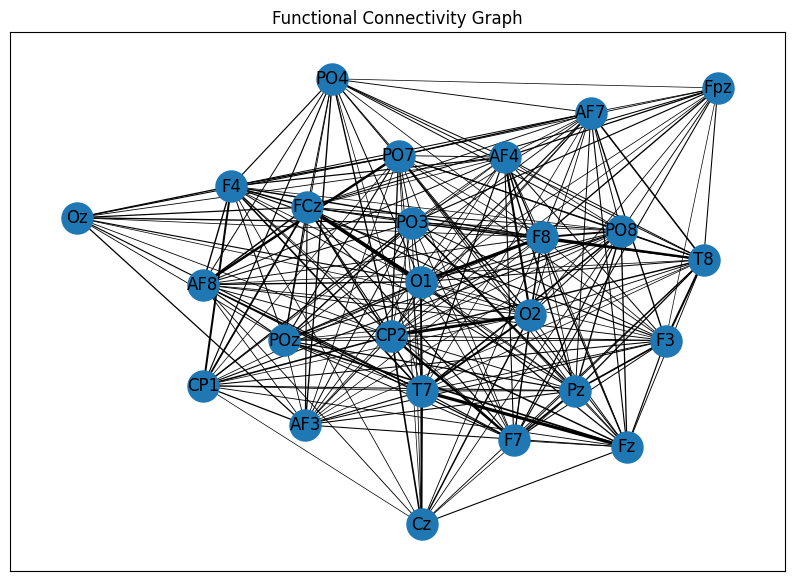

In [27]:
plot_connectivity_graph(importance_dict, threshold=0.001)

In [28]:
def plot_topographical_map(importance_dict, selected_electrodes):
    # Create MNE Info object with selected electrodes
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=selected_electrodes, sfreq=512, ch_types='eeg')
    info.set_montage(montage)

    # Create arrays to store band importances for each electrode
    band_names = ['Delta', 'Theta', 'Alpha', 'Beta']
    band_importances = {band: np.zeros(len(selected_electrodes)) for band in band_names}

    # Aggregate importances for each electrode
    for conn, score in importance_dict.items():
        e1, e2, band = conn.split('-')
        idx1 = selected_electrodes.index(e1)
        idx2 = selected_electrodes.index(e2)
        band_importances[band][idx1] += score
        band_importances[band][idx2] += score

    # Plot topographical maps for each band
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for idx, band in enumerate(band_names):
        im, _ = mne.viz.plot_topomap(
            band_importances[band], info, axes=axes[idx], show=False, cmap='viridis'
        )
        axes[idx].set_title(f'{band} Band')
    
    # Add a colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label('Feature Importance')
    plt.suptitle("Topographical Maps of Electrode Importances by Frequency Band", fontsize=16)
    plt.show()

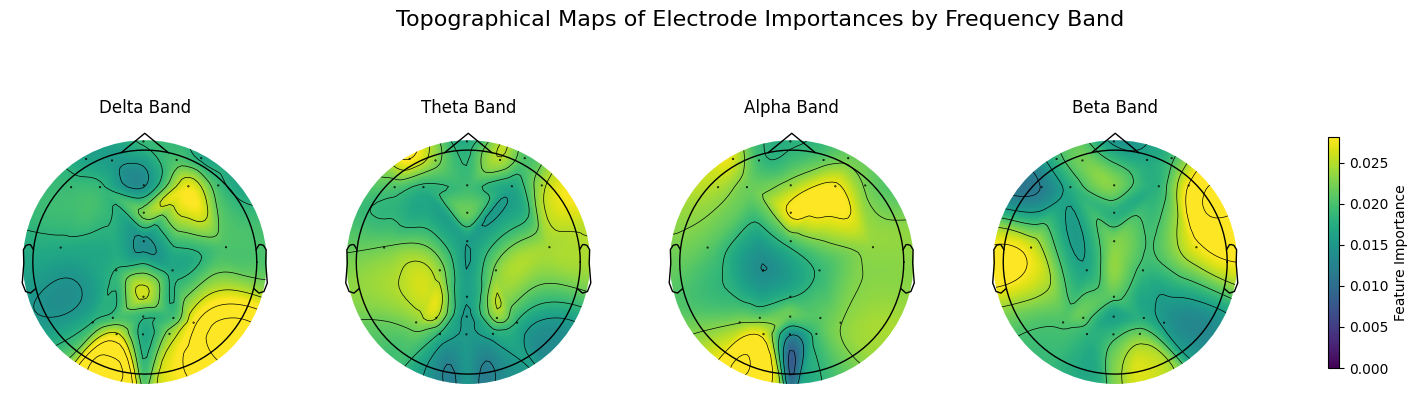

In [29]:
plot_topographical_map(importance_dict, selected_electrodes)

In [30]:
def plot_feature_importances(sorted_importance):
    # Extract top 10 features
    top_features = sorted_importance[:10]
    labels = [f"{conn}" for conn, _ in top_features]
    scores = [score*100 for _, score in top_features]

    plt.figure(figsize=(10, 6))
    plt.barh(labels, scores, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Connection (Electrodes - Band)")
    plt.title("Top 10 Most Important Connectivity Features")
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.grid(True)
    plt.show()

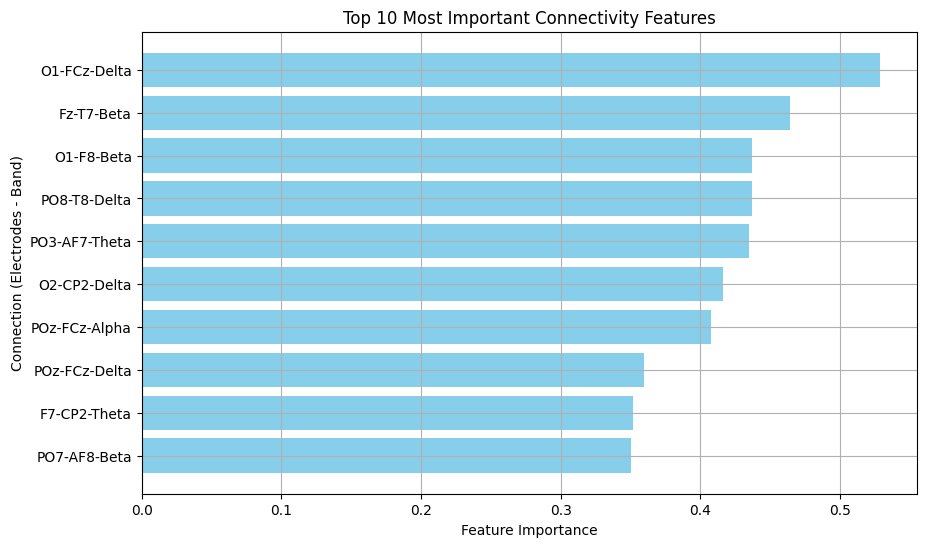

In [31]:
plot_feature_importances(sorted_importance)